# Optimizing Landscape Reconstruction
*Oliver Cheng, Zosia Adamska, Megan Engel*

This notebook is a brief example on how to use the `barrier_crosing` module in order to iteratively reconstruct a free energy landscape from the dynamics of a Brownian particle pulled by a harmonic trap moving according to a bespoke protocol. This library implements Hummer & Szabo's Free Energy Landscape Reconstruction method (2001) on arbitrary work + position data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.random as random
import jax.numpy as jnp
import matplotlib.pyplot as plt
# Barrier Crossing Imports

import barrier_crossing.models as bcm
import barrier_crossing.plotting as bcu
import importlib

I0000 00:00:1740505068.820270  396345 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


We start by simulating a brownian particle on a double well landscape.

In [4]:
p = importlib.import_module("figures.param_set.double_well.params_10kt")
param_set = p.param_set
param_set

SCParameters(N=1, dim=1, shift=<function free.<locals>.shift_fn at 0x149cb0626830>, mass=1e-17, temperature=4.183, gamma=950681818181.8181, beta=0.2390628735357399, init_position_fwd=Array([[-10.]], dtype=float32), init_position_rev=Array([[10.]], dtype=float32), k_s=1.0, end_time=0.0001, dt=2e-07, Neq=1000, D=440000.0, x_m=10.0, delta_E=0.0, kappa_l=0.2579925539421075, kappa_r=0.2579925539421075)

In [5]:
energy_fn = param_set.energy_fn() # Double well potential
position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.) # Creates a linear schedule from -10 to 10.

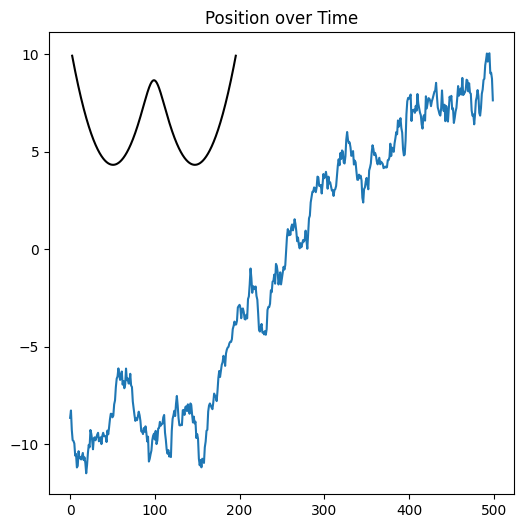

In [6]:
key = random.PRNGKey(1001)
positions, log_prob, works = param_set.simulate_fn(position_schedule, ks_trap_fn = False, key = key, regime = "brownian")

fig = plt.figure(figsize = (6,6))
plt.plot(positions.reshape(-1))
plt.title("Position over Time")
bcu.add_energy_fn_plot(param_set, fig = fig)
fig.savefig("test.png")

# Optimize Schedule With JAX-MD Autodiff

In [7]:
import barrier_crossing.train as bct
import barrier_crossing.iterate_landscape as bcla
import barrier_crossing.loss as loss

import optax

batch_size = 1000 # Number of simultaneous simulations to run
num_epochs = 100

learning_rate = optax.exponential_decay(0.1, num_epochs, 0.5, end_value = 0.001)
optimizer = optax.adam(learning_rate)

position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.)

auto_diff_simulate_fn = lambda model_to_train, key: param_set.simulate_fn(model_to_train, ks_trap_fn = False, key = key)

grad_fn = lambda N: loss.estimate_gradient_work(N, auto_diff_simulate_fn, position_schedule)

losses = bct.train(position_schedule, optimizer, grad_fn, key, batch_size, num_epochs)
coeffs = position_schedule.coef_hist

Optimize Protocol: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.15it/s]


Text(0.5, 0, 'Epochs')

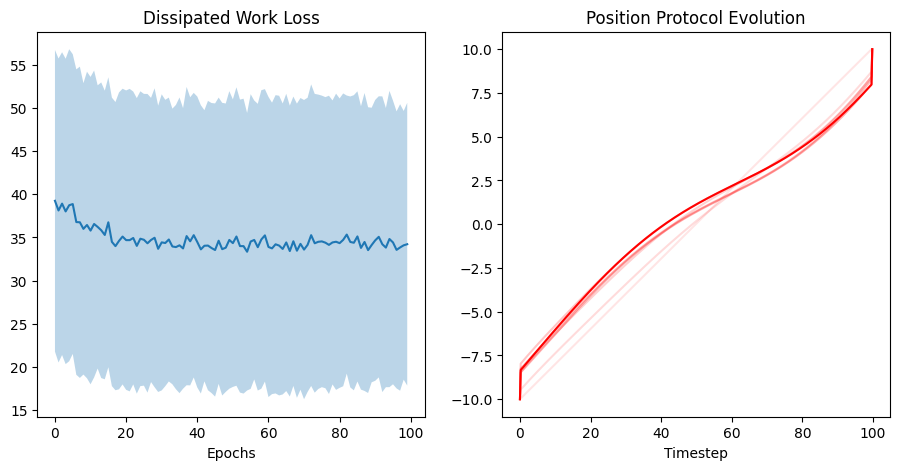

In [8]:
_, (loss_ax, protocol_ax) = plt.subplots(1, 2, figsize = (11,5))

bcu.plot_evolving(ax = protocol_ax, model = position_schedule, color = "red")
protocol_ax.set_title("Position Protocol Evolution")
protocol_ax.set_xlabel("Timestep")

bcu.plot_with_stdev(losses, ax = loss_ax, axis = 1)
loss_ax.set_title("Dissipated Work Loss")
loss_ax.set_xlabel("Epochs")

# Reconstructions
This package implements Hummer & Szabo's Single-Molecule Free Energy Landscape Reconstruction formula about a reaction coordinate.

Reconstructing with Optimized protocol: 100%|██████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


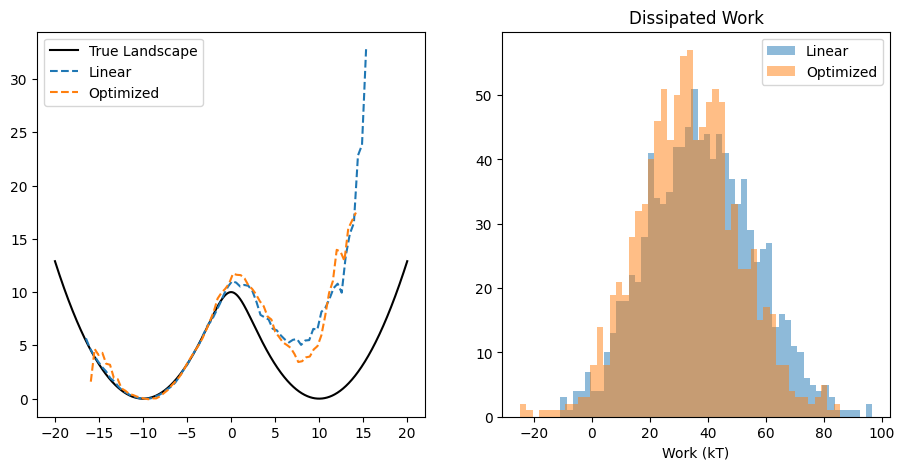

In [9]:
import barrier_crossing.simulate as bcs
import barrier_crossing.iterate_landscape as bcla
from tqdm import tqdm

_, (ax_landscape, ax_hist) = plt.subplots(1,2, figsize = (11, 5))
batch_size = 1000
bins = 70
num_reconstructions = 10

protocols = {
    "Linear": position_schedule.protocol(position_schedule.coef_hist[0]), 
    "Optimized": position_schedule.protocol(position_schedule.coef_hist[num_epochs])}

reconstructed_landscapes = []
reconstructed_labels = []
all_works = []
for protocol_type, position_protocol in protocols.items():
    energies = []
    for _ in tqdm(range(num_reconstructions), desc = f"Reconstructing with {protocol_type} protocol"):
        key, split = random.split(key)
        no_key_simulate_fn = lambda key: param_set.simulate_fn(position_protocol, ks_trap_fn = False, key = key, regime = "brownian")

        # Run `batch_size` simulations vectorized.
        _, (trajectories, works, _) = bcs.batch_simulate_harmonic(batch_size, no_key_simulate_fn, key)
        
        midpoints, E = bcla.energy_reconstruction(
                        jnp.cumsum(works, axis=1), 
                        trajectories, 
                        bins, 
                        position_protocol,
                        param_set.k_s,
                        param_set.simulation_steps, 
                        batch_size, 
                        param_set.beta)

        energies.append(E)
    energies = bcla.interpolate_inf(jnp.mean(jnp.array(energies), axis = 0))
    
    reconstructed_landscapes.append([midpoints, energies])
    reconstructed_labels.append(protocol_type)
    all_works.append(works)
    
bcu.plot_landscapes(param_set, reconstructed_landscapes, reconstructed_labels, ax = ax_landscape)
ax_landscape.legend()

for name, work in zip(reconstructed_labels, all_works):
    ax_hist.hist(work.sum(axis = 1), bins = 50, label = name, alpha = 0.5)
ax_hist.set_title("Dissipated Work")
ax_hist.set_xlabel("Work (kT)")
ax_hist.legend()

# Iterative Landscape Reconstruction
In real life examples such as in hairpin pulling experiments, the true underlying free energy landscape is unknown, and we seek to understand the landscape through experiment. Below implements the iterative method whereby protocols are optimized with brownian particle simulations on top of "guesses" of landscapes, which are reconstructed from trajectory data of MD simulations or real pulling experiments.

The implementation of this procedure requires three components:
1. Two simulators: one which simulates under an arbitrary Hamiltonian for which we are attempting to find the free energy landscape of, and another which will simulate a brownian particle in "guess" of the landscape. The second simulator must be autodifferentiable in order to learn a bespoke schedule.
2. A reconstructor: This package implements Hummer & Szabo's method which adapts the Weighted Histogram Analysis Method (WHAM) to recover free energy estimates across a landscape using simulation trajectories.
3. A trainer: by backpropagating gradients through the molecular dynamics simulator, the trainer uses gradient descent to learn a schedule which minimizes a loss (dissipated work or Jarzynski Error).

In [10]:
bcla = importlib.reload(bcla)
opt_batch_size = 1000
opt_steps_landscape = 300
max_iter = 7
position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.)

true_simulation_fwd = lambda trap_fn, ks_fn: lambda keys: p.param_set.simulate_fn(
  trap_fn, 
  ks_fn,
  keys, 
  regime = "brownian",
  fwd = True)

sim_no_E = lambda energy_fn: lambda trap_fn, ks_fn, keys: p.param_set.simulate_fn(
  trap_fn, 
  ks_fn,
  keys, 
  regime = "brownian",
  fwd = False,
  custom = energy_fn)

reconstruct_fn = lambda batch_works, trajectories, position_fn, stiffness_fn, batch_size: \
  bcla.energy_reconstruction(batch_works, 
                            trajectories, 
                            bins, 
                            position_fn, 
                            stiffness_fn, 
                            param_set.simulation_steps,
                            batch_size, 
                            param_set.beta)

grad_no_E = lambda model, simulate_fn: lambda num_batches: loss.estimate_gradient_work(
    num_batches,
    simulate_fn,
    model)

train_fn = lambda model, grad_fn, key: bct.train(model, optimizer, grad_fn, key, batch_size = opt_batch_size, num_epochs = opt_steps_landscape)

it_landscapes, it_coeffs, losses = bcla.optimize_landscape(
  max_iter,
  batch_size,
  position_schedule,
  true_simulation_fwd,
  sim_no_E,
  grad_no_E,
  reconstruct_fn,
  train_fn,
  key,
  num_reconstructions = 10)

Optimize Landscape:   0%|                                                                        | 0/7 [00:00<?, ?it/s]

Infinities found in energy reconstruction. Continuing through interpolation...


Optimize Landscape: 100%|████████████████████████████████████████████████████████████████| 7/7 [03:31<00:00, 30.24s/it]


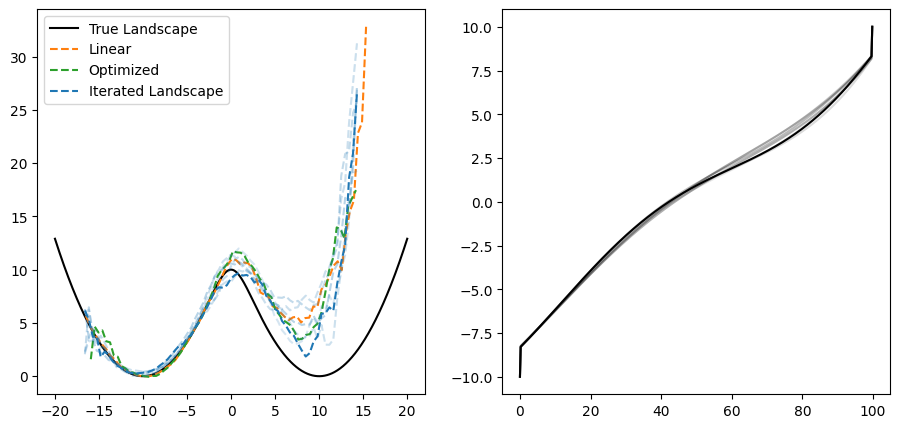

In [11]:

plotting_pos_sched = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.)

_, (ax_landscapes, ax_protocols) = plt.subplots(1,2, figsize = (11,5))

energies = jnp.array([landscape[1] for landscape in it_landscapes])

bcu.plot_evolving(ax = ax_protocols, model = plotting_pos_sched, coeffs = it_coeffs)


bcu.plot_landscapes(param_set, ax = ax_landscapes, landscapes = [it_landscapes] + reconstructed_landscapes, labels = ["Iterated Landscape"] + reconstructed_labels, iterated_index = 0)

ax_landscapes.legend()